#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импортируем библиотеки

In [1]:
# установим последнюю версию scikit-learn#
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 49 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score,
    TimeSeriesSplit,
    cross_validate
)

from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import (
    mean_squared_error,
    make_scorer
)

In [3]:
# игнорирование предупреждений
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [4]:
# константа
RANDOM_STATE = 12345

### Загружаем и получаем информацию о датасете

**Считаем данные из csv-файлов в датафрейм и сохраним в переменные data.**

Данные находятся в файле:

- taxi.csv 

Путь к файлу:

- /datasets/taxi.csv

In [5]:
data = pd.read_csv('/datasets/taxi.csv',parse_dates=True, index_col=[0])

**Функция по выводу основной информации по датафреймам**

In [6]:
def all_info(data):

    
    print('\033[1m'+'1.Вывод первых 5 строк датафрейма'+'\033[0m')
    print('')
    display(data.head())
    print('')
    
    print('\033[1m'+'2.Выведим основную информацию о датафрейме.'+'\033[0m')
    print('')
    display(data.info())
    print('')
    
    print('Посмотрим на уникальные значения в столбцах базы данных.')
    print('')
    for i in data.columns:
        print('Кол-во уникальных значений в столбце', i, ':', data[i].nunique())
        print(pd.Series(data[i]).unique())
        print('')
    
    
    a = []
    b = []
    c = []
    count = 0
    for value in data.columns:
        a.append(data[value].isna().sum())
        b.append((data[value].isna().sum()/len(data))*100)
        c.append(value)
        count += 1

    f = pd.DataFrame( {'name_columns': pd.Series(c),
                       'count': pd.Series(a),
                      'count,%': pd.Series(b)}
                    )
    print('')
    print('\033[1m'+'3.Таблица пропусков по столбцам.'+'\033[0m')
    print('')
    display(f.sort_values(by=['count'], ascending=False))
    print('')
    print('Колв-во столбцов с пропусками:', len(f[f['count']>0]))
    print('')
    
    print('\033[1m'+'4.Кол-во уникальных дупликатов.'+'\033[0m')
    print('')
    print('Уникальных дупликатов:', data.duplicated().sum())
    print('')
    
    
    print('\033[1m'+'5.Выведим общую информацию о данных в столбцах.'+'\033[0m')
    print('')
    display(data.describe())
    print('')
    
    
    print('\033[1m'+'6.Построение общей гистограммы для всех числовых столбцов таблицы'+'\033[0m')
    print('')
    data.hist(bins = 100, figsize=(15, 10))
    plt.show()
    print('')

1.Вывод первых 5 строк датафрейма



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



2.Выведим основную информацию о датафрейме.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


Посмотрим на уникальные значения в столбцах базы данных.

Кол-во уникальных значений в столбце num_orders : 81
[  9  14  28  20  32  21   7   5  17  12  19  25  22   8   6   4  10  13
   2   3   0   1  11  15  16  23  18  33  24  26  30  38  34  42  31  27
  36  29  35  56  37  40  39  45  49  58  68  43  53  44  41  52  46  57
  47  64  61  50  48  55  62  54  71  78 119  99  51  60  87  90  94  82
  80  91  76  66  65  98  81  95  67]


3.Таблица пропусков по столбцам.



,name_columns,count,"count,%"
0,num_orders,0,0.0



Колв-во столбцов с пропусками: 0

4.Кол-во уникальных дупликатов.

Уникальных дупликатов: 26415

5.Выведим общую информацию о данных в столбцах.



,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



6.Построение общей гистограммы для всех числовых столбцов таблицы



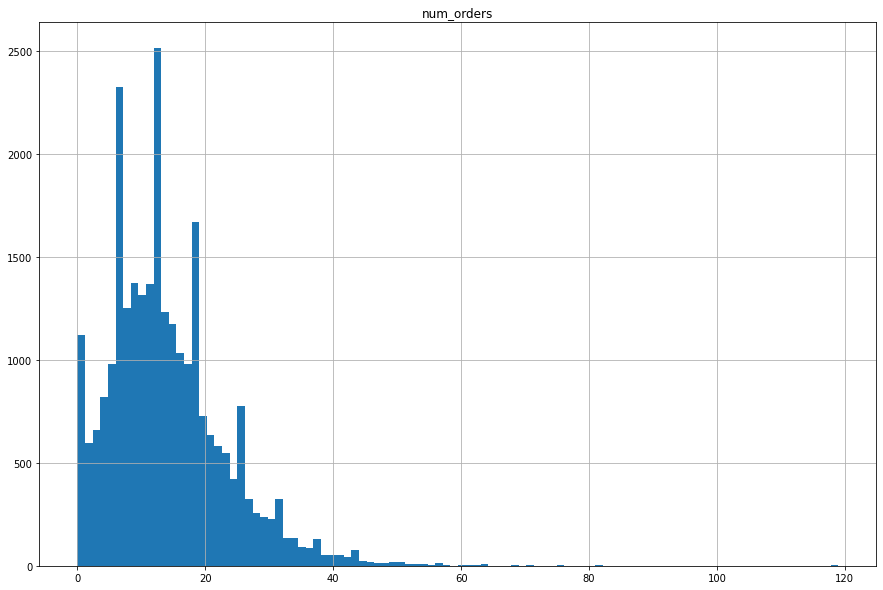

In [7]:
all_info(data)

Проверим, в хронологическом ли порядке расположены даты и время

In [8]:
print(data.index.is_monotonic)

True


Данные расположены в хронологическом порядке

Псомтрим на уникальные значения, чтобы посомтреть за какой период нам предоставлены данные

In [9]:
data.index.unique()

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

In [10]:
data.index[0]

Timestamp('2018-03-01 00:00:00')

In [11]:
data.index[len(data)-1]

Timestamp('2018-08-31 23:50:00')

Данные преставлены с 1 марта 2018 по 31 августа 2018. Данные представлены за 6 месяцев. Данные предоставлены с шагом в 10 минут

### Вывод ###

В даннном пункте был загружен датасет и проведена превая оценка исходных данных. При чтение файла столбец с датами мы преобразовали в индексы нашего датасета.

- Строк: 26496. Столбцов: 1
- Кол-во столбцов с пропусками: 0. 
- Уникальные дупликатов 26415. Однако их удалять не будем. 
- Cтолбцы соответсвуют своего типу данных
- Данные расположены в хронологическом порядке
- аномалий в значениях не наблюдаются
- Данные преставлены с 1 марта 2018 по 31 августа 2018. Данные представлены за 6 месяцев. Данные предоставлены с шагом в 10 минут

## Анализ

**Построим график временного ряда**

Text(0.5, 1.0, 'График заказов такси во времени')

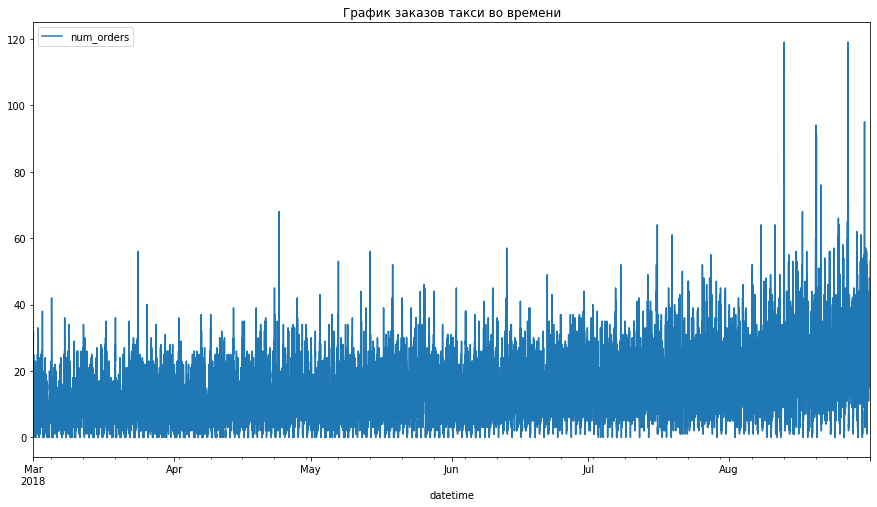

In [12]:
data.plot(figsize=(15, 8))
plt.title('График заказов такси во времени')

Значения не удобные для изучения.

**Выполним Ресемплирование по одному часу**

In [13]:
data = data.resample('1H').sum()

Text(0.5, 1.0, 'График заказов такси. Ресемплирование по одному часу')

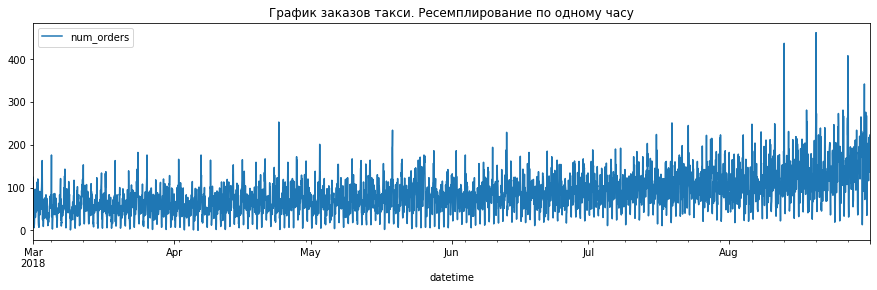

In [14]:
data.plot(figsize=(15, 4))
plt.title('График заказов такси. Ресемплирование по одному часу')

График тоже мало информативен. Посмотрим как данные меняются при ресемплирование по дням, по неделям, по месяцам

Text(0.5, 1.0, 'График заказов такси. Ресемплирование по одному дню')

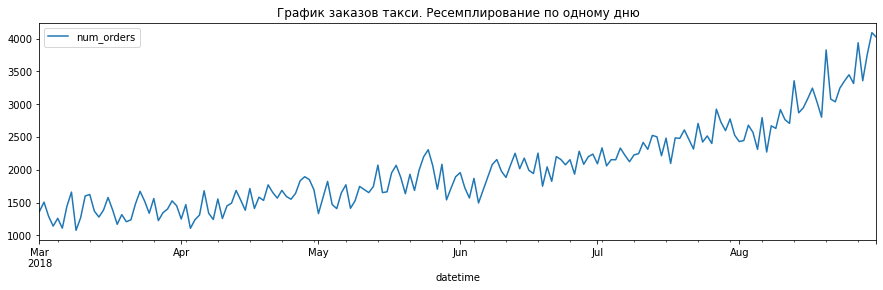

In [15]:
data.resample('1D').sum().plot(figsize=(15, 4))
plt.title('График заказов такси. Ресемплирование по одному дню')

Text(0.5, 1.0, 'График заказов такси. Ресемплирование по одной неделе')

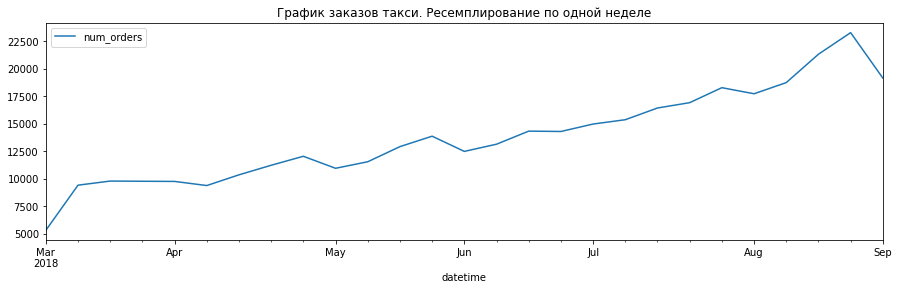

In [16]:
data.resample('1W').sum().plot(figsize=(15, 4))
plt.title('График заказов такси. Ресемплирование по одной неделе')

Text(0.5, 1.0, 'График заказов такси. Ресемплирование по одному месяцу')

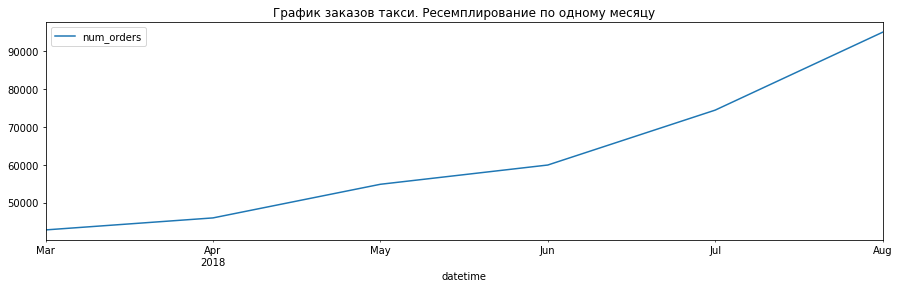

In [17]:
data.resample('1M').sum().plot(figsize=(15, 4))
plt.title('График заказов такси. Ресемплирование по одному месяцу')

Можно наблюдать, что суммарное кол-во заказов со временем у комании растет. Особенно если смотреть по месяцам. Однако в зависимости от недели и дня наблюдаются колебания роста и спада. Видно, что в какие-то дни кол-во заказов больше, а в какие-то меньше. Необходиом будет затем исследовать данную зависимость.

**Скользящее среднее**

In [18]:
data_1 = data.copy()
data_1['rolling_mean'] = data['num_orders'].rolling(10).mean() 
data_1['std'] = data['num_orders'].rolling(10).std()

<AxesSubplot:xlabel='datetime'>

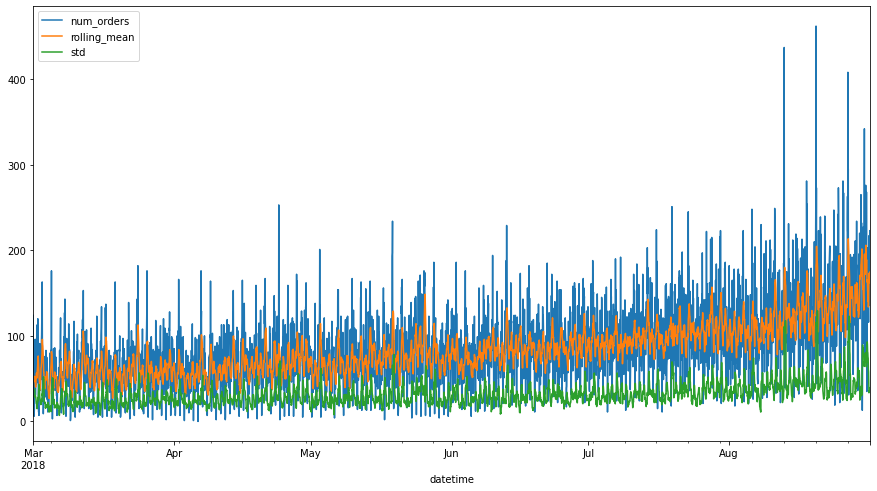

In [19]:
data_1.plot(figsize=(15, 8))

Ряд не станционарный. Среднее значение менятеся со временем.

**Тренды и сезонность**

In [20]:
def  seasonal(data):
    decomposed = seasonal_decompose(data['num_orders']) 

    plt.figure(figsize=(15, 10))

    plt.subplot(311)

    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()


Рассмотрим тренд и сезонность на всем временном участке

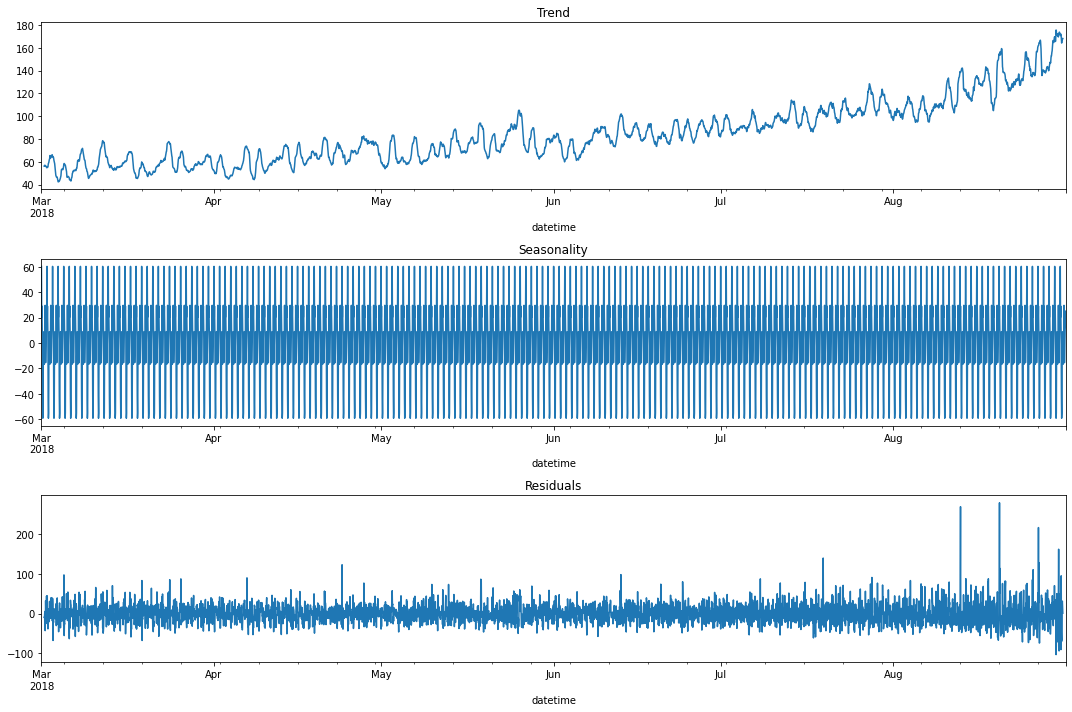

In [21]:
seasonal(data_1)

Тренд у нас растет с незначительными колебаниям, но стабильно вверх. Наблюдается Сезонность. Попробуем ее выявить рассмотрев последний день, неделю и месяц в датасете.

Изменение кол-ва заказов в течении последней дня августа

<AxesSubplot:xlabel='datetime'>

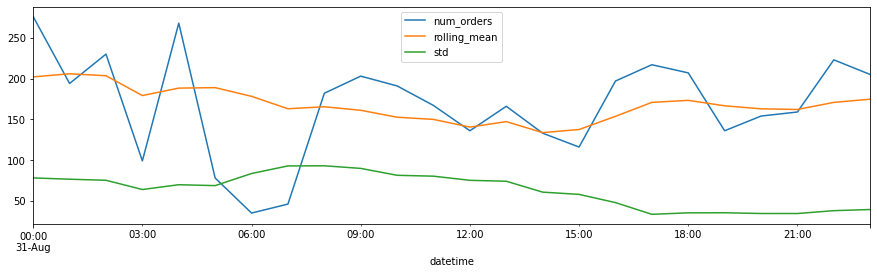

In [22]:
data_1.loc['2018-08-31 00:00:00':'2018-08-31 23:50:00'].plot(figsize=(15, 4))

Тренд и сезонность в течении последней недели августа

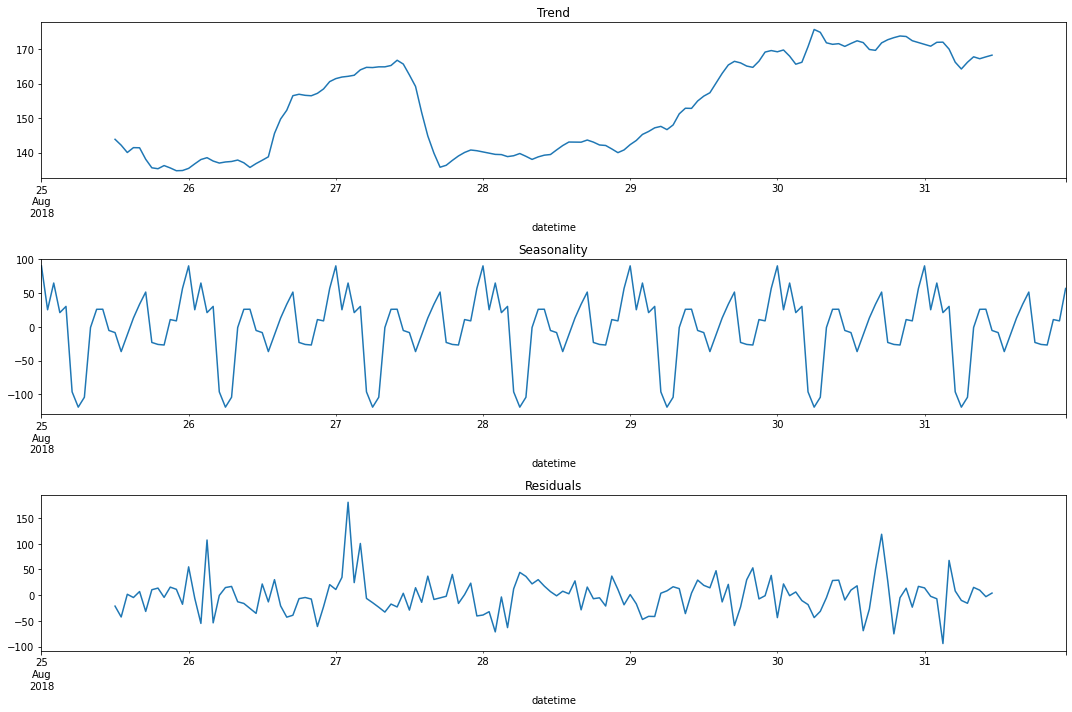

In [23]:
seasonal(data_1['2018-08-25 00:00:00':'2018-08-31 23:50:00'])

Тренд и сезонность в течении августа

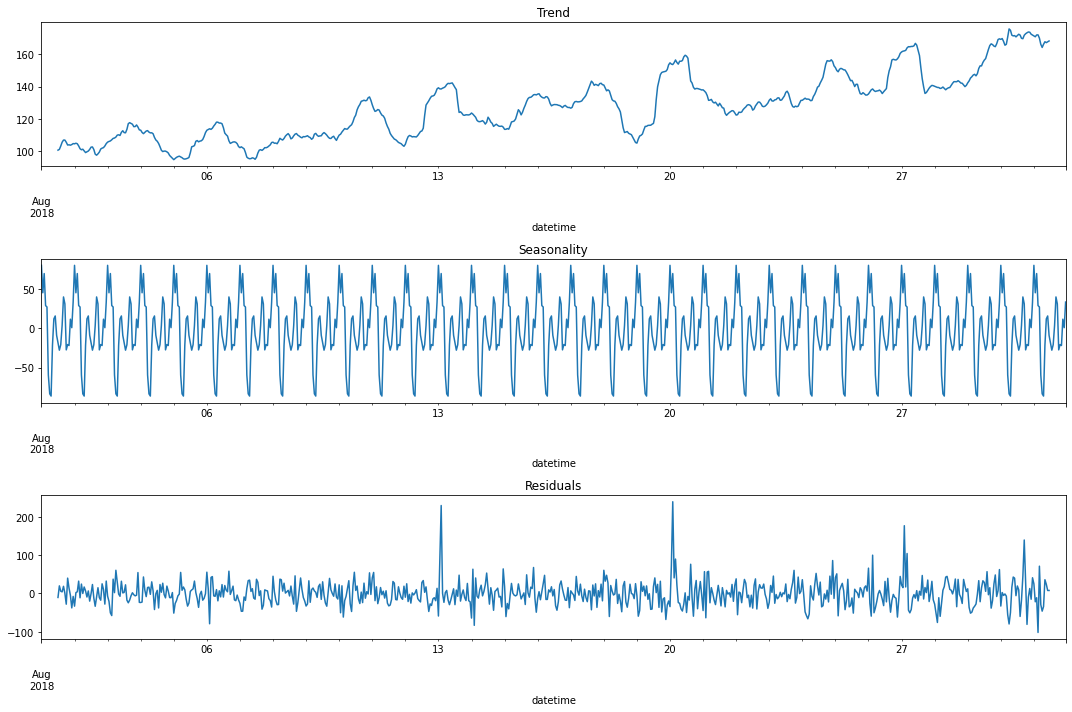

In [24]:
seasonal(data_1['2018-08-01 00:00:00':'2018-08-31 23:50:00'])

По тренду и сезонности можно наблюдать в августе, что спрос на такси выпадал на 6, 13,20 и 27 августа 

In [25]:
print('День недели 2018-08-27:', data_1['2018-08-27'].index.dayofweek.unique())
print('День недели 2018-08-20:',data_1['2018-08-20'].index.dayofweek.unique())
print('День недели 2018-08-13:',data_1['2018-08-13'].index.dayofweek.unique())
print('День недели 2018-08-06:',data_1['2018-08-06'].index.dayofweek.unique())

День недели 2018-08-27: Int64Index([0], dtype='int64', name='datetime')
День недели 2018-08-20: Int64Index([0], dtype='int64', name='datetime')
День недели 2018-08-13: Int64Index([0], dtype='int64', name='datetime')
День недели 2018-08-06: Int64Index([0], dtype='int64', name='datetime')


Можно заметить, что это один и тот же день. А именно понедельник. В понедельник возрастает спрос на такси в аэропорту. 

Посмотрим кол-ва спроса в популярные дни в августе

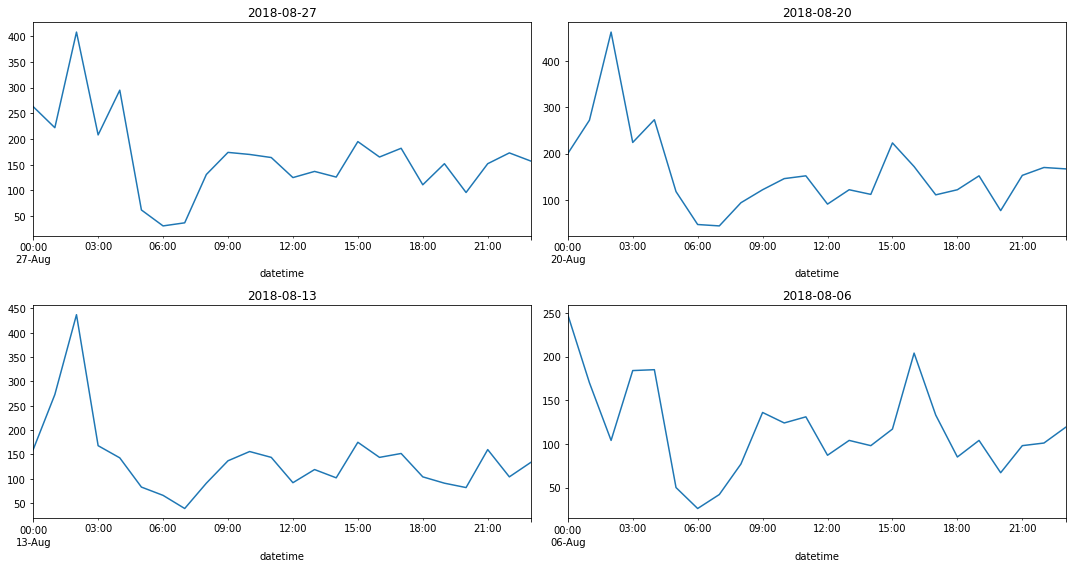

In [26]:
    plt.figure(figsize=(15, 10))

    plt.subplot(221)

    data_1.loc['2018-08-27 00:00:00':'2018-08-27 23:50:00','num_orders'].plot(figsize=(15, 8))
    plt.title('2018-08-27')

    plt.subplot(222)
    data_1.loc['2018-08-20 00:00:00':'2018-08-20 23:50:00','num_orders'].plot(figsize=(15, 8))
    plt.title('2018-08-20')

    plt.subplot(223)
    data_1.loc['2018-08-13 00:00:00':'2018-08-13 23:50:00','num_orders'].plot(figsize=(15, 8))
    plt.title('2018-08-13')
    
    plt.subplot(224)
    data_1.loc['2018-08-06 00:00:00':'2018-08-06 23:50:00','num_orders'].plot(figsize=(15, 8))
    plt.title('2018-08-06')
    plt.tight_layout()

Посмотрим кол-ва спроса в выборочне непопулярные дни в августе на последней неделе

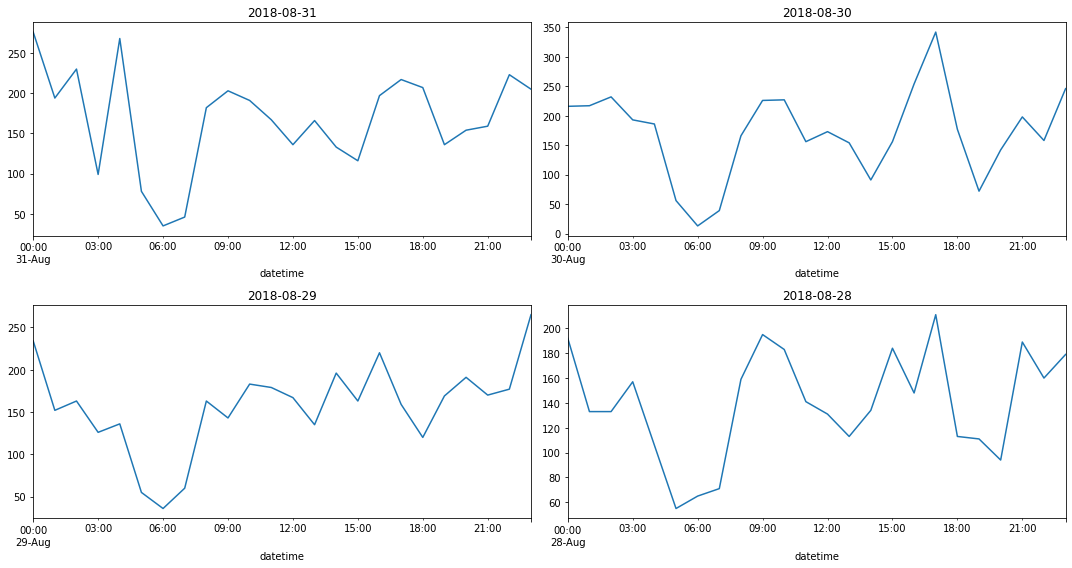

In [27]:
    plt.figure(figsize=(15, 10))

    plt.subplot(221)

    data_1.loc['2018-08-31 00:00:00':'2018-08-31 23:50:00','num_orders'].plot(figsize=(15, 8))
    plt.title('2018-08-31')

    plt.subplot(222)
    data_1.loc['2018-08-30 00:00:00':'2018-08-30 23:50:00','num_orders'].plot(figsize=(15, 8))
    plt.title('2018-08-30')

    plt.subplot(223)
    data_1.loc['2018-08-29 00:00:00':'2018-08-29 23:50:00','num_orders'].plot(figsize=(15, 8))
    plt.title('2018-08-29')
    
    plt.subplot(224)
    data_1.loc['2018-08-28 00:00:00':'2018-08-28 23:50:00','num_orders'].plot(figsize=(15, 8))
    plt.title('2018-08-28')
    plt.tight_layout()

В выходные, спрос падает. Самое не популярное время ориентровочно в 6 утра. В остальное время спрос средний. В некоторые дни срос возрастает в период утром ближе к 9, вечером ближе к 16-17 вечера и иногда ночью к 1-2 часам.

### Вывод ###

В даннном пункте были проанализированы предоставленные данные во времени.

- было замеченно, среднее значение спроса к услугам такси растет со временем.Ряд не станционарный.
- наблюдается сезонность дня.
- даты не влияют на спрос. влияет день недели. было замечено, что очень большой спрос каждый понедельник.
- по выходным срос маленький
- временные периода спроса ориентировочно: 9-10ч, 16-17ч и 1-2ч ночи

## Обучение

### Подготовка целевого признака и признаков


**Создание признаков**

Создадим функцию, которая формуирует признаки. Из дат для признаков выделим час,день недели и месяц. Так  как по трендам и сезонности было замечено, что рост не зависил от даты. А год рассматривается один. (В принципе можно было также не включать и месяц, так как по представленным данным не было замечено, что он влияет на результат. Но такие точные выводы лучше делать если данные будут предтсвлены за весь год. А то вдруг окажется,к примеру, что спрос растет к лету стабильно, так как начинается сезон отпусков и люди чаще летают и следовательно чаще пользуются такси)

In [28]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [29]:
# сощдаем признаки
make_features(data, 6, 10)

**Тренировочная и тестовая выборка**

Делим данные на тренировочную и тестовую выборку. Под тестовую выборку выделяем 10% данных.

In [30]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

Удаляем строки с пустыми значениями.

In [31]:
train = train.dropna() 

In [32]:
print(train.shape)
print(test.shape)

(3964, 11)
(442, 11)


Проверим, что даннные разбились последовательно во времени

In [33]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 10:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


**Выделяем целевой признак и признаки**

In [34]:
feature_train = train.drop(['num_orders'],axis=1)
target_train =  train['num_orders']

feature_test = test.drop(['num_orders'],axis=1)
target_test =  test['num_orders']

In [35]:
feature_train.head()

,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-03-01 10:00:00,3,3,10,69.0,34.0,15.0,12.0,6.0,43.0,52.5
2018-03-01 11:00:00,3,3,11,64.0,69.0,34.0,15.0,12.0,6.0,46.5
2018-03-01 12:00:00,3,3,12,96.0,64.0,69.0,34.0,15.0,12.0,47.6
2018-03-01 13:00:00,3,3,13,30.0,96.0,64.0,69.0,34.0,15.0,43.5
2018-03-01 14:00:00,3,3,14,32.0,30.0,96.0,64.0,69.0,34.0,40.1


**Масштабируем данные**

In [36]:
numeric = feature_train.select_dtypes(exclude='object').columns.to_list()
print(numeric)

['month', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'rolling_mean']


In [37]:
scaler = StandardScaler()
scaler.fit(feature_train[numeric])
feature_train[numeric] = scaler.transform(feature_train[numeric])
feature_test[numeric] = scaler.transform(feature_test[numeric])

In [38]:
feature_train.head()

,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-03-01 10:00:00,-1.416685,-0.012842,-0.216801,-0.241750,-1.146815,-1.637562,-1.714475,-1.868592,-0.910959,-1.108356
2018-03-01 11:00:00,-1.416685,-0.012842,-0.072267,-0.371124,-0.241335,-1.146003,-1.636850,-1.713364,-1.868109,-1.366561
2018-03-01 12:00:00,-1.416685,-0.012842,0.072267,0.456868,-0.370689,-0.240499,-1.145222,-1.635750,-1.712895,-1.319223
2018-03-01 13:00:00,-1.416685,-0.012842,0.216801,-1.250865,0.457178,-0.369857,-0.239593,-1.144196,-1.635288,-1.495663
2018-03-01 14:00:00,-1.416685,-0.012842,0.361335,-1.199115,-1.250298,0.458032,-0.368969,-0.238702,-1.143779,-1.641979


### Обучение моделей

В данном пункте будут рассмотрены 4 модели машинного обучения:
1. Ridge
2. LinearRegression
3. LightGBM
4. CatBoost

In [39]:
all_model =['Ridge','LinearRegression','LightGBM','CatBoost']

In [40]:
all_rmse = []

In [41]:
all_parametrs = []

#### Ridge

In [42]:
%%time
model_ridge = Ridge(random_state=RANDOM_STATE)

CPU times: user 20 µs, sys: 3 µs, total: 23 µs
Wall time: 26.9 µs


In [43]:
%%time
# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0, 0.2, 0.01),
}

tscv = TimeSeriesSplit(n_splits=10)

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    cv=tscv,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

CPU times: user 110 µs, sys: 0 ns, total: 110 µs
Wall time: 83.9 µs


In [44]:
%%time
gs_ridge.fit(feature_train, target_train)

CPU times: user 1.62 s, sys: 1.15 s, total: 2.77 s
Wall time: 2.97 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Ridge(random_state=12345), n_jobs=-1,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])},
             scoring='neg_root_mean_squared_error')

In [45]:
# лучшее значение RMSE 
print(f'best_score: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}')

best_score: 31.10177454934965
best_params: {'alpha': 0.19}


In [46]:
all_rmse.append(gs_ridge.best_score_ * -1)
all_parametrs.append(gs_ridge.best_params_)

#### LinearRegression()

In [47]:
%%time
model_linear = LinearRegression()

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 15.7 µs


In [48]:
%%time

start_time = time.time()

model_linear.fit(feature_train, target_train)

end_time = time.time()

linear_model_time = end_time - start_time 

print(linear_model_time)

0.003964662551879883
CPU times: user 4.31 ms, sys: 1.17 ms, total: 5.48 ms
Wall time: 4.11 ms


In [49]:
time_split = TimeSeriesSplit(n_splits=10)

In [50]:
%%time

start_time = time.time()

scores = cross_val_score(
    model_linear, 
    feature_train, 
    target_train, 
    cv=tscv, 
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

end_time = time.time()

linear_prediction_time = end_time - start_time 
                        
linear_score = abs(scores.mean())**.5

CPU times: user 95.7 ms, sys: 65.7 ms, total: 161 ms
Wall time: 177 ms


In [51]:
print(linear_score)

31.45894452538132


In [52]:
print(linear_prediction_time)

0.1771221160888672


In [53]:
all_rmse.append(linear_score)
all_parametrs.append('n_splits=10')

#### LightGBM

In [54]:
%%time
model_gbm = lgb.LGBMRegressor(num_threads=8)

CPU times: user 89 µs, sys: 23 µs, total: 112 µs
Wall time: 41.2 µs


In [55]:
param_grid_gbm = {
    'num_leaves':[30,50], 
    'learning_rate':[0.2,0.5],
    'random_state':[RANDOM_STATE]
                 }
tscv = TimeSeriesSplit(n_splits=10)

In [56]:
%%time
gs_gbm = GridSearchCV(
    model_gbm,
    param_grid=param_grid_gbm,
    cv=tscv,
    scoring='neg_root_mean_squared_error')

CPU times: user 15 µs, sys: 4 µs, total: 19 µs
Wall time: 21.7 µs


In [57]:
%%time
gs_gbm.fit(feature_train, target_train)

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM]

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LGBMRegressor(num_threads=8),
             param_grid={'learning_rate': [0.2, 0.5], 'num_leaves': [30, 50],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error')

In [58]:
# лучшее значение RMSE 
print(f'best_score: {gs_gbm.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_gbm.best_params_}')

best_score: 25.15695543582861
best_params: {'learning_rate': 0.2, 'num_leaves': 30, 'random_state': 12345}


In [59]:
all_rmse.append(gs_gbm.best_score_ * -1)
all_parametrs.append(gs_gbm.best_params_)

#### CatBoost

In [60]:
%%time
model_catboost = CatBoostRegressor(
    verbose=False,
    loss_function='RMSE'
)

CPU times: user 140 µs, sys: 6 µs, total: 146 µs
Wall time: 151 µs


In [61]:
param_grid_catboost = {
    'depth'         : [6,8],
    'learning_rate' : [0.01,0.02,0.03],
    'iterations'    : [20,50,100],
    'random_state'  : [RANDOM_STATE]
}
tscv = TimeSeriesSplit(n_splits=10)

In [62]:
%%time
gs_catboost = GridSearchCV(
    model_catboost,
    param_grid=param_grid_catboost,
    cv=tscv,
    scoring='neg_root_mean_squared_error')

CPU times: user 20 µs, sys: 1 µs, total: 21 µs
Wall time: 24.8 µs


In [63]:
%%time
gs_catboost.fit(feature_train, target_train)

CPU times: user 32.2 s, sys: 2.81 s, total: 35 s
Wall time: 4min 5s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f10c35d5e80>,
             param_grid={'depth': [6, 8], 'iterations': [20, 50, 100],
                         'learning_rate': [0.01, 0.02, 0.03],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error')

In [64]:
# лучшее значение RMSE 
print(f'best_score: {gs_catboost.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_catboost.best_params_}')

best_score: 26.093572373872764
best_params: {'depth': 8, 'iterations': 100, 'learning_rate': 0.03, 'random_state': 12345}


In [65]:
all_rmse.append(gs_catboost.best_score_ * -1)
all_parametrs.append(gs_catboost.best_params_)

In [66]:
result_1 = pd.DataFrame([all_model,
                        all_parametrs,
                        all_rmse], 
                        index=['model',
                               'best_parametrs',
                               'rmse'])

**Итого:**

In [67]:
pd.options.display.max_colwidth = 0
result_1.T

,model,best_parametrs,rmse
0,Ridge,{'alpha': 0.19},31.101775
1,LinearRegression,n_splits=10,31.458945
2,LightGBM,"{'learning_rate': 0.2, 'num_leaves': 30, 'random_state': 12345}",25.156955
3,CatBoost,"{'depth': 8, 'iterations': 100, 'learning_rate': 0.03, 'random_state': 12345}",26.093572


Лучшие рещультаты по RMSE у LightGBM. 
Посмотрим Как модели вычисляются с лучшими гиперпараметрами.

### Анализ моделей

Нашли гиперпараметры моделй, которые дают RMSE меньше 48. Обучим модели на данных параметрах и посомтрим сколько времени занимает их обучение и предсказание

#### Ridge

In [68]:
%%time
model_ridge_1 = Ridge(
    alpha=0.19,
    random_state=RANDOM_STATE
)

CPU times: user 20 µs, sys: 1 µs, total: 21 µs
Wall time: 24.3 µs


In [69]:
%%time
start_time = time.time()

model_ridge_1.fit(feature_train, target_train)

end_time = time.time()

ridge_model_time = end_time - start_time 

CPU times: user 3.93 ms, sys: 176 µs, total: 4.11 ms
Wall time: 2.92 ms


In [70]:
%%time

start_time = time.time()
predictions_1 = model_ridge_1.predict(feature_train)
end_time = time.time()

ridge_prediction_time = end_time - start_time 

CPU times: user 5.66 ms, sys: 382 µs, total: 6.04 ms
Wall time: 1.82 ms


In [71]:
print(ridge_prediction_time)

0.0017838478088378906


In [72]:
%%time
score_ridge = mean_squared_error(target_train,predictions_1)**.5
print(f'score: {score_ridge}')

score: 30.630592598129514
CPU times: user 1.22 ms, sys: 55 µs, total: 1.28 ms
Wall time: 1.13 ms


#### LinearRegression()

Модель была обучена ранее. 

#### LightGBM

In [73]:
%%time
model_gbm_1 = lgb.LGBMRegressor(
    num_leaves=30,
    learning_rate=0.2,
    random_state=RANDOM_STATE,
    num_threads=8
)

CPU times: user 36 µs, sys: 2 µs, total: 38 µs
Wall time: 41.7 µs


In [74]:
%%time

start_time = time.time()

model_gbm_1.fit(feature_train, target_train)

end_time = time.time()

gbm_model_time = end_time - start_time 

CPU times: user 1.16 s, sys: 20.9 ms, total: 1.18 s
Wall time: 1.21 s


In [75]:
print(gbm_model_time)

1.2105605602264404


In [76]:
%%time

start_time = time.time()
predictions_3 = model_gbm_1.predict(feature_train)
end_time = time.time()

gbm_prediction_time = end_time - start_time 

CPU times: user 51.5 ms, sys: 3.41 ms, total: 54.9 ms
Wall time: 61.2 ms


In [77]:
print(gbm_prediction_time)

0.06113076210021973


In [78]:
%%time
score_gbm = mean_squared_error(target_train,predictions_3)**.5
print(f'score: {score_gbm}')

score: 11.932305850038446
CPU times: user 1.07 ms, sys: 48 µs, total: 1.12 ms
Wall time: 902 µs


#### CatBoost

In [79]:
model_catboost_1 = CatBoostRegressor(
    verbose=False,
    loss_function='RMSE',
    depth=8,
    learning_rate=0.03,
    iterations=100,
    random_state=RANDOM_STATE)

In [80]:
%%time

start_time = time.time()
model_catboost_1.fit(feature_train, target_train)
end_time = time.time()

catboost_model_time = end_time - start_time 

CPU times: user 537 ms, sys: 31.1 ms, total: 568 ms
Wall time: 1.6 s


In [81]:
print(catboost_model_time)

1.6044268608093262


In [82]:
%%time

start_time = time.time()
predictions_4 = model_catboost_1.predict(feature_train)
end_time = time.time()

catboost_prediction_time = end_time - start_time 

CPU times: user 2.09 ms, sys: 0 ns, total: 2.09 ms
Wall time: 1.72 ms


In [83]:
print(catboost_prediction_time)

0.0016925334930419922


In [84]:
score_catboost = mean_squared_error(target_train,predictions_4)**.5
print(f'score: {score_catboost}')

score: 22.80646764952637


#### Лучшая модель

In [85]:
time_learning = [ridge_model_time,
                 linear_model_time,
                 gbm_model_time,
                 catboost_model_time]

time_prediction = [ridge_prediction_time,
                   linear_prediction_time,
                   gbm_prediction_time,
                   catboost_prediction_time]

In [86]:
result_2 = pd.DataFrame([all_model,
                        all_parametrs,
                        all_rmse,
                        time_learning,
                        time_prediction], 
                        index=['model',
                               'best_parametrs',
                               'rmse',
                              'Время обучение',
                              'Время предсказания'])

Итого результаты с заданными гиперпараметрами:

In [87]:
result_2.T

,model,best_parametrs,rmse,Время обучение,Время предсказания
0,Ridge,{'alpha': 0.19},31.101775,0.002856,0.001784
1,LinearRegression,n_splits=10,31.458945,0.003965,0.177122
2,LightGBM,"{'learning_rate': 0.2, 'num_leaves': 30, 'random_state': 12345}",25.156955,1.210561,0.061131
3,CatBoost,"{'depth': 8, 'iterations': 100, 'learning_rate': 0.03, 'random_state': 12345}",26.093572,1.604427,0.001693


Лучшие результаты по RMSE у модели LightGBM, однако у Ridge неплохие показатели времени на обучение и предсказание.
Думаю клиенту в данному случае разнича в  ms критичной не будет, а вот показатель в RMSE будет выйгрышней. Поэтому выберем модель LightGBM

## Тестирование

Проверим модель LightGBM на тестовой выборке

In [88]:
%%time
predictions_5 = model_gbm_1.predict(feature_test)

CPU times: user 4.19 ms, sys: 13 µs, total: 4.2 ms
Wall time: 3.8 ms


In [89]:
%%time
score_gbm_test = mean_squared_error(target_test,predictions_5)**.5
print(f'score: {score_gbm_test}')

score: 44.318147238743876
CPU times: user 1.44 ms, sys: 0 ns, total: 1.44 ms
Wall time: 1.23 ms


In [90]:
predictions_taxi = pd.DataFrame(data = predictions_5, 
                                columns = ['predictions'], 
                                index = feature_test.index.copy())

In [91]:
predictions_taxi.head()

,predictions
datetime,
2018-08-13 14:00:00,97.004461
2018-08-13 15:00:00,112.831727
2018-08-13 16:00:00,129.221730
2018-08-13 17:00:00,127.922557
2018-08-13 18:00:00,107.429838


In [92]:
target_test.head()

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
Freq: H, Name: num_orders, dtype: int64

In [93]:
taxi_sravnenie = pd.merge(target_test, 
                  predictions_taxi, 
                  how = 'left', left_index = True, right_index = True)

In [94]:
taxi_sravnenie.head()

,num_orders,predictions
datetime,,
2018-08-13 14:00:00,102,97.004461
2018-08-13 15:00:00,175,112.831727
2018-08-13 16:00:00,144,129.221730
2018-08-13 17:00:00,152,127.922557
2018-08-13 18:00:00,104,107.429838


In [95]:
taxi_sravnenie.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_orders   442 non-null    int64  
 1   predictions  442 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 10.4 KB


In [96]:
taxi_sravnenie['predictions'] = taxi_sravnenie['predictions'].astype('int64')

In [97]:
taxi_sravnenie.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   num_orders   442 non-null    int64
 1   predictions  442 non-null    int64
dtypes: int64(2)
memory usage: 10.4 KB


График прогноз-факта для тестового периода лучшей модели за весь рассматриваемый период тестовой выборки

<AxesSubplot:xlabel='datetime'>

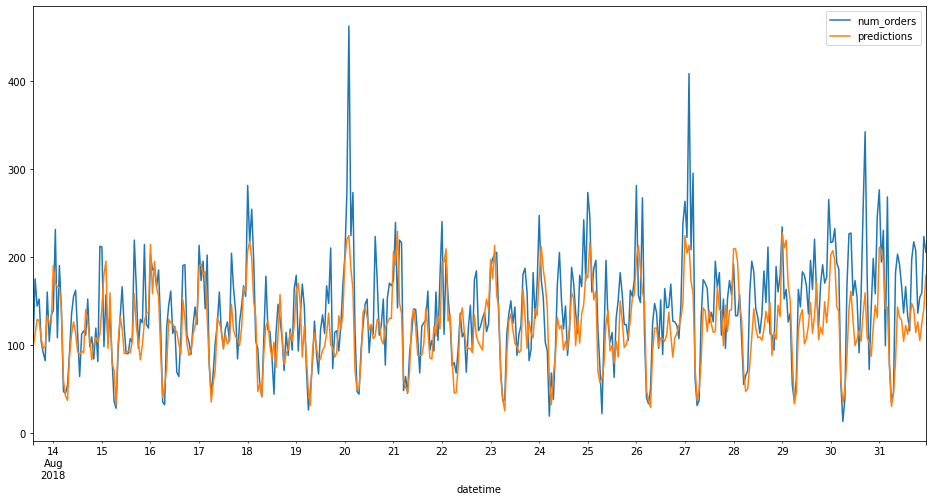

In [98]:
taxi_sravnenie.plot(figsize=(16, 8))

График прогноз-факта для тестового периода лучшей модели за последнюю неделю августа

<AxesSubplot:xlabel='datetime'>

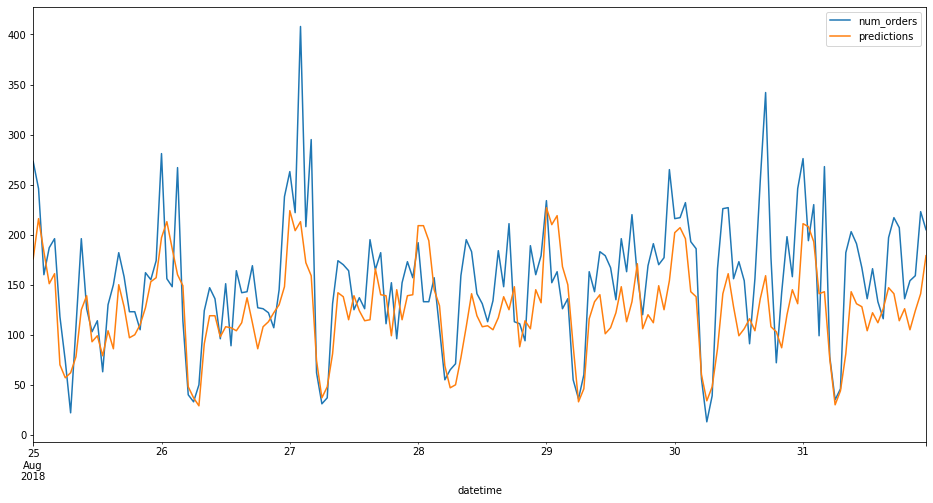

In [99]:
taxi_sravnenie['2018-08-25 00:00:00':'2018-08-31 23:50:00'].plot(
    figsize=(16, 8)
)

Можно заметить по графикам, что тенденция в верному предсказанию наблюдается, но сейчас пока что модель предсказывает чуть меньше ожидаемых закзаов

Значение метрики RMSE на тестовой выборке не больше 48. Следовательно мы построили модель для предсказания.
Стоит отметить, что на тетсовой RMSE больше чем на тренировочной выборке, значит модель можно еще улучшить, подобрав другие гиперпарамтеры. Однако условие в начале проекта мы выолнили. 

## Итог итогов

По заданию необходимо построить модель для предсказания количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки, на основании исторических данных о заказах такси в аэропортах, которые предоставила компания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


Для выполнения данного проекта были выполнены следущие шаги:

- ШАГ 1

В даннном пункте был загружен датасет и проведена превая оценка исходных данных. При чтение файла столбец с датами мы преобразовали в индексы нашего датасета.

- Строк: 26496. Столбцов: 1
- Кол-во столбцов с пропусками: 0. 
- Уникальные дупликатов 26415. Однако их удалять не будем. 
- Cтолбцы соответсвуют своего типу данных
- Данные расположены в хронологическом порядке
- аномалий в значениях не наблюдаются
- Данные преставлены с 1 марта 2018 по 31 августа 2018. Данные представлены за 6 месяцев. Данные предоставлены с шагом в 10 минут

- ШАГ 2

В даннном пункте были проанализированы предоставленные данные во времени.

- было замеченно, среднее значение спроса к услугам такси растет со временем.Ряд не станционарный.
- наблюдается сезонность дня.
- даты не влияют на спрос. влияет день недели. было замечено, что очень большой спрос каждый понедельник.
- по выходным срос маленький
- временные периода спроса ориентировочно: 9-10ч, 16-17ч и 1-2ч ночи


- ШАГ 3

В данном пункте были рассмотрены 4 модели машинного обучения:
1. Ridge
2. LinearRegression
3. LightGBM
4. CatBoost

Данные были предварительно разделены на тренировочную и тестовую выборку в соотношение 90:10.
Проведено масштабирование данных.
Созданы признаки


Итого результаты с заданными гиперпараметрами:

In [100]:
result_2.T

,model,best_parametrs,rmse,Время обучение,Время предсказания
0,Ridge,{'alpha': 0.19},31.101775,0.002856,0.001784
1,LinearRegression,n_splits=10,31.458945,0.003965,0.177122
2,LightGBM,"{'learning_rate': 0.2, 'num_leaves': 30, 'random_state': 12345}",25.156955,1.210561,0.061131
3,CatBoost,"{'depth': 8, 'iterations': 100, 'learning_rate': 0.03, 'random_state': 12345}",26.093572,1.604427,0.001693


Лучшие результаты по RMSE у модели LightGBM, однако у Ridge неплохие показатели времени на обучение и предсказание.
Думаю клиенту в данному случае разнича в  ms критичной не будет, а вот показатель в RMSE будет выйгрышней. Поэтому выберем модель LightGBM


- ШАГ 4

На тестовой выборке результаты :
- RMSE 44.31814
- время обучения:5.68 s 
- время предсказания: 26.9 ms